# 1. Import

In [17]:
# 1.1 Import required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE, RFECV, SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc
from collections import Counter
from imblearn.over_sampling import SMOTE


# 1.2 Import data and split it into features and targets
data = pd.read_csv("../data/processedData.csv")
X, y = data.loc[:, data.columns != 'Revenue'], data.loc[:, data.columns == 'Revenue']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

cts_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
X_train_cts = X_train[cts_columns]
X_train_dis = X_train.drop(columns=cts_columns)
X_test_cts = X_test[cts_columns]
X_test_dis = X_test.drop(columns=cts_columns)

# 2. Data Standardization

In [19]:
scaler = StandardScaler()
X_train_cts = pd.DataFrame(data=scaler.fit_transform(X_train_cts), columns=cts_columns)
X_train_dis.reset_index(inplace=True, drop=True)
X_train = pd.concat([X_train_cts, X_train_dis], axis=1)

X_test_cts = pd.DataFrame(data=scaler.transform(X_test_cts), columns=cts_columns)
X_test_dis.reset_index(inplace=True, drop=True)
X_test = pd.concat([X_test_cts, X_test_dis], axis=1)

# 3. Feature Engineering

<Axes: ylabel='Feature'>

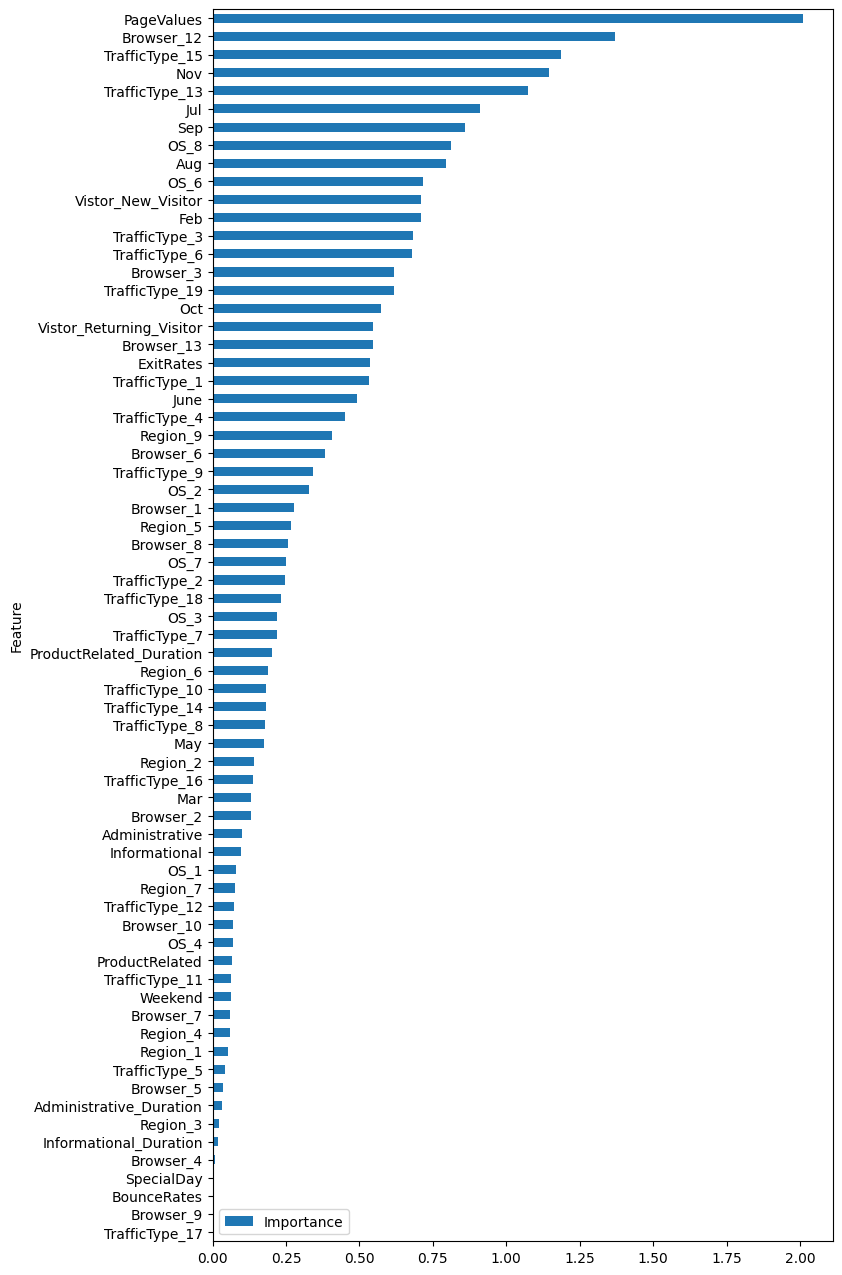

In [5]:
# Investigate Feature Importance
model = LogisticRegression(class_weight='balanced', solver='newton-cholesky', max_iter=1500)
model.fit(X_train, y_train['Revenue'])

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 16))

In [ ]:
# Performed VIF to check multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = pd.DataFrame([variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))])

print(vif_data[vif_data['feature'].isin(cts_columns)])

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                   feature       VIF
0           Administrative  2.127673
1  Administrative_Duration  1.785255
2            Informational  2.137867
3   Informational_Duration  1.980114
4           ProductRelated  3.955946
5  ProductRelated_Duration  3.631359
6              BounceRates  6.927727
7                ExitRates  7.883394
8               PageValues  1.080465
9               SpecialDay  1.334120


By correlation matrix in preprocessing, BounceRates and ExitRates has high correlation (0.91). The VIF scores show both of them have high relation with other variables too. Since the feature importance of ExitRates is higher than that of BounceRates, we would drop BounceRates and test again

In [20]:
X = X.drop(columns=['BounceRates'])
X_train = X_train.drop(columns=['BounceRates'])
X_test = X_test.drop(columns=['BounceRates'])

In [ ]:
# Performed VIF to check multicollinearity again
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = pd.DataFrame([variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))])

print(vif_data[vif_data['feature'].isin(cts_columns)])

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                   feature       VIF
0           Administrative  2.120250
1  Administrative_Duration  1.784785
2            Informational  2.137635
3   Informational_Duration  1.979841
4           ProductRelated  3.896941
5  ProductRelated_Duration  3.629722
6                ExitRates  1.359388
7               PageValues  1.071387
8               SpecialDay  1.329625


<Axes: >

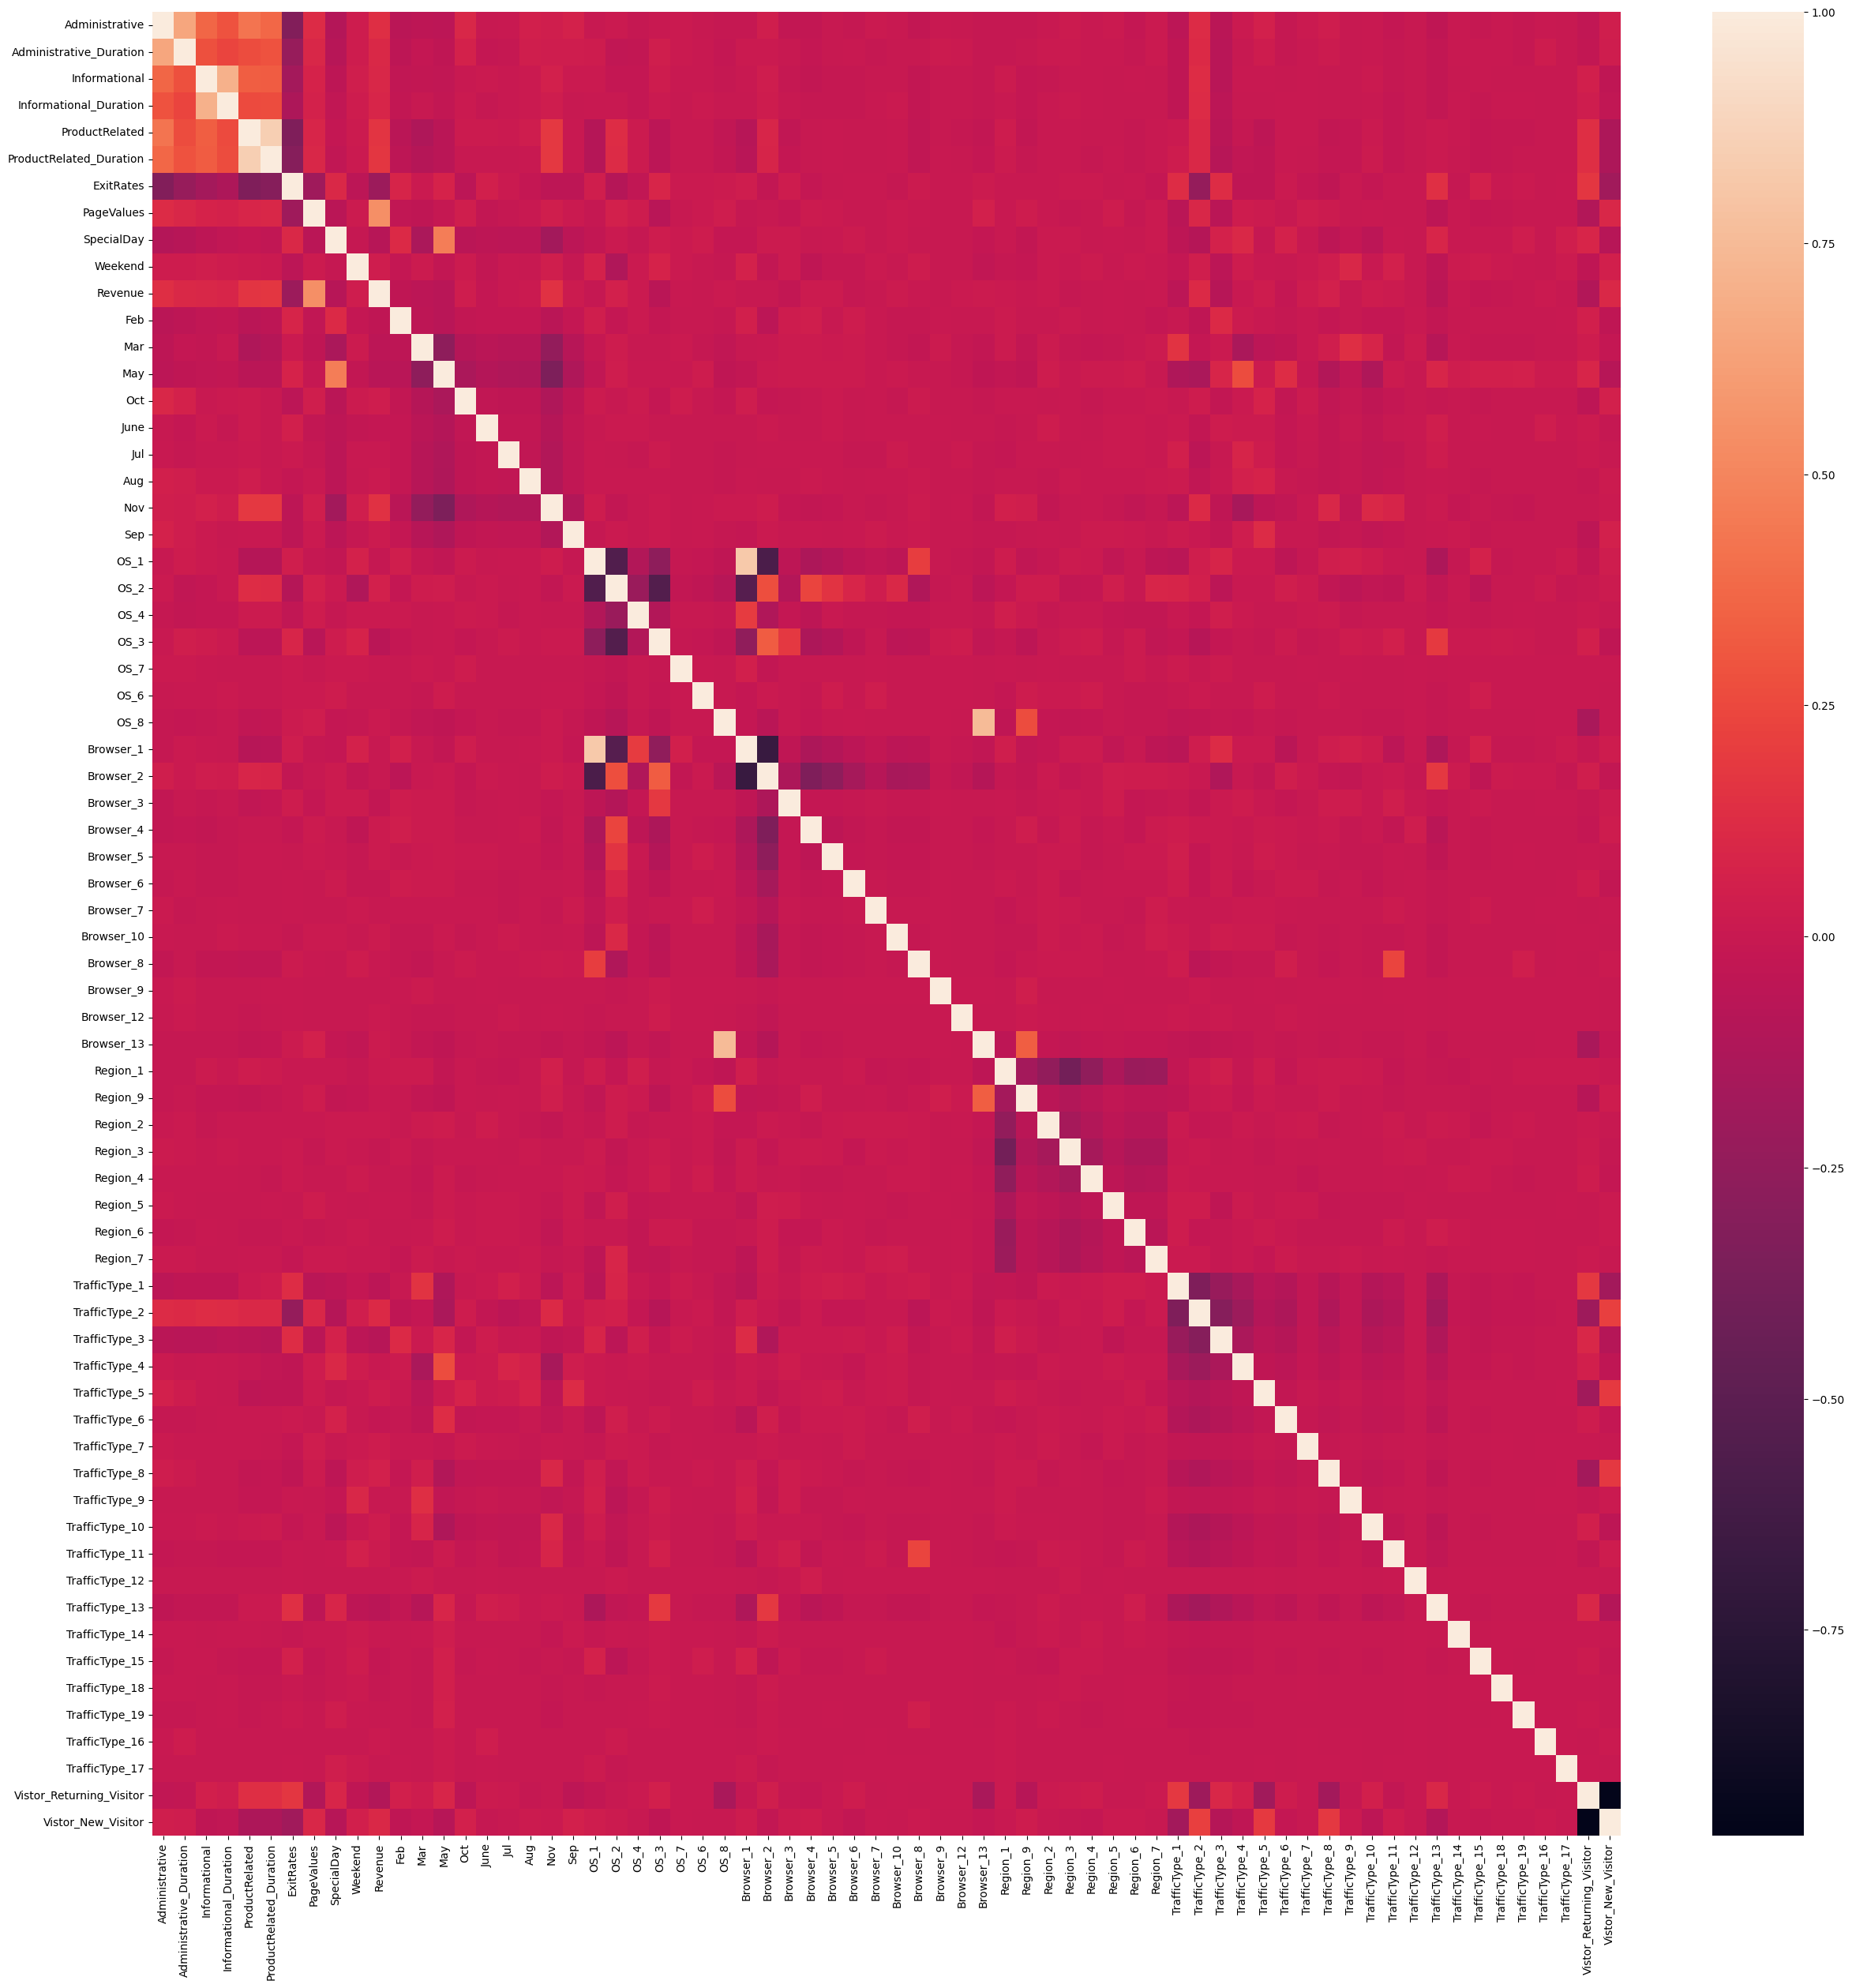

In [ ]:
# Check Correlation Matrix again
data = data.drop(columns=['BounceRates'])
plt.subplots(1, 1, figsize=(30, 30))
data_correlation = data.corr()
sns.heatmap(data=data_correlation)#, annot=True, cmap='coolwarm', fmt=".2f")

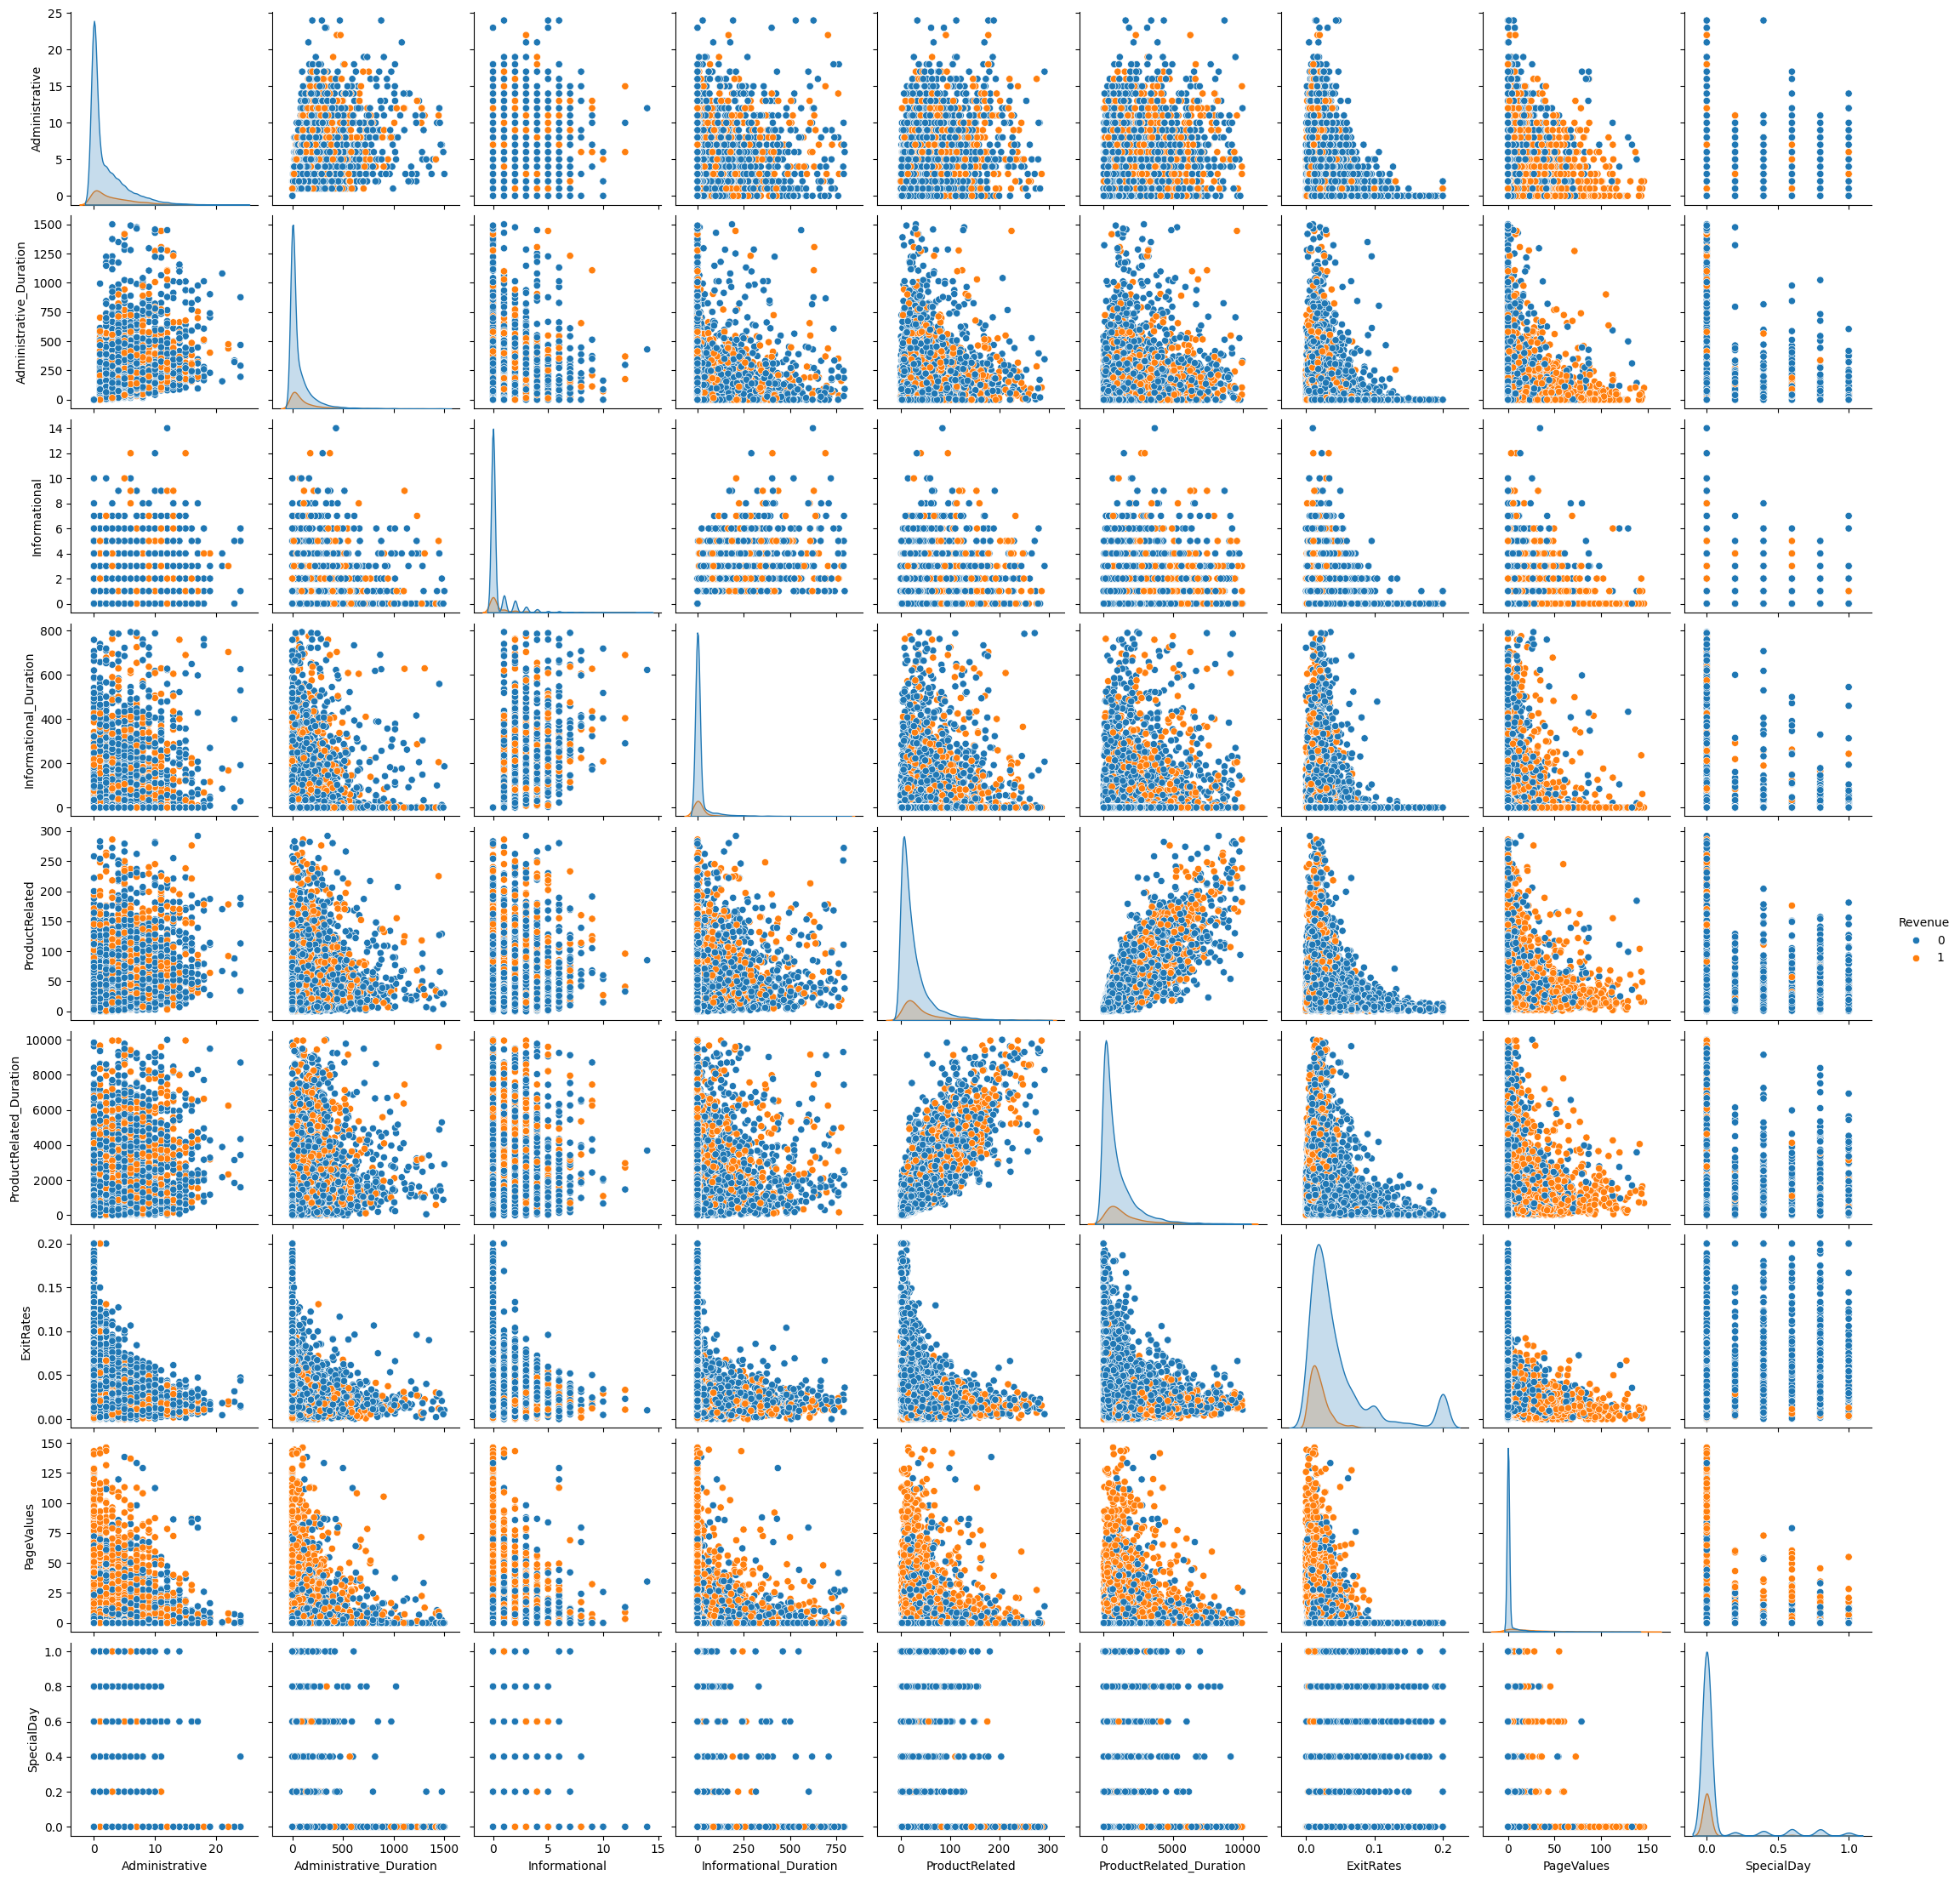

In [ ]:
# Check Correlation between continuous variables
sns.pairplot(data=data[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'SpecialDay', 'Revenue']], hue='Revenue')

# 4. Feature Selection + Model Construction
RFECV Model: use Recursive feature elimination with cross-validation to select features.

0. Basic RFECV Model
1. RFECV Model with class weight
2. RFECV Model with SMOTE Sampling

## 0. Baseline Model

Training set accuracy 0.8900031014163134
Testing set accuracy 0.892517569243489
Balanced training set accuracy 0.8335527742518611
Balanced testing set accuracy 0.892517569243489


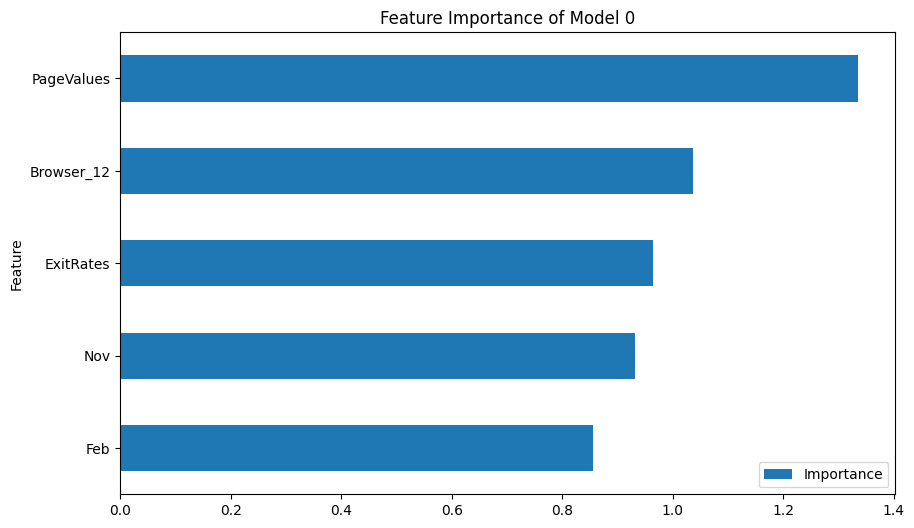

In [62]:
# RFECV: use Recursive feature elimination with cross-validation to select features.
# solver='newton-cholesky'
estimator = LogisticRegression(solver='newton-cholesky', max_iter=100)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)
selector = RFECV(estimator, step=1, cv=cv)
selector = selector.fit(X_train, y_train['Revenue'])

RFECV_model_0 = LogisticRegression(solver='newton-cholesky')

RFECV_model_0.fit(X_train[X_train.columns[selector.get_support()]], y_train['Revenue'])

# Print feature importances of selected features
coefficients = RFECV_model_0.coef_[0]

feature_importance_0 = pd.DataFrame({'Feature': X.columns[selector.get_support()], 'Importance': np.abs(coefficients)})
feature_importance_0 = feature_importance_0.sort_values('Importance', ascending=True)
feature_importance_0.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title='Feature Importance of Model 0')
plt.savefig("feature_importance_model_0.png")

# Perform Prediction and print accuracy
y_train_pred_0 = RFECV_model_0.predict(X_train[X_train.columns[selector.get_support()]])
y_test_pred_0 = RFECV_model_0.predict(X_test[X_train.columns[selector.get_support()]])


print("Training set accuracy", accuracy_score(y_train_pred_0, y_train))
print("Testing set accuracy", accuracy_score(y_test_pred_0, y_test))


print("Balanced training set accuracy", balanced_accuracy_score(y_train_pred_0, y_train))
print("Balanced testing set accuracy", accuracy_score(y_test_pred_0, y_test))

For testing data: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2055
           1       0.77      0.41      0.53       364

    accuracy                           0.89      2419
   macro avg       0.84      0.69      0.74      2419
weighted avg       0.88      0.89      0.88      2419



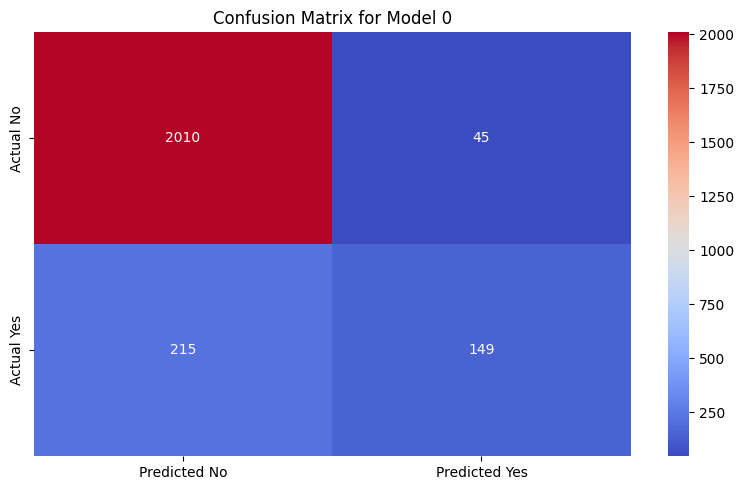

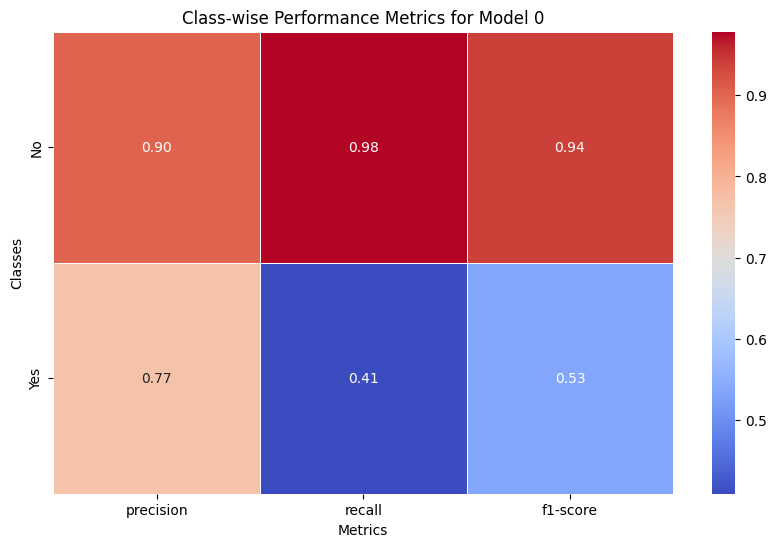

In [47]:
# Visualize the output of testing set

# Classification Report
classification_report_01=classification_report(y_test, y_test_pred_0)
print("For testing data: ")
print(classification_report_01)

# Confusion matrix with seaborn Heatmap
conf_matrix_0=confusion_matrix(y_test, y_test_pred_0)
# Seaborn Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix_0, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Model 0')
plt.tight_layout()
plt.savefig("confusion_matrix_model_0.png")

# Visualize classification report better: Class-wise Performance Metrics
classification_report_02 = classification_report(y_test, y_test_pred_0, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [classification_report_02[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Model 0')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("performance_metrics_model_0.png")
plt.show()

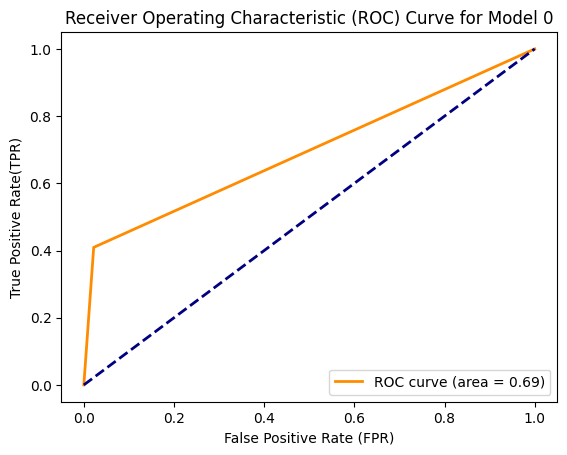

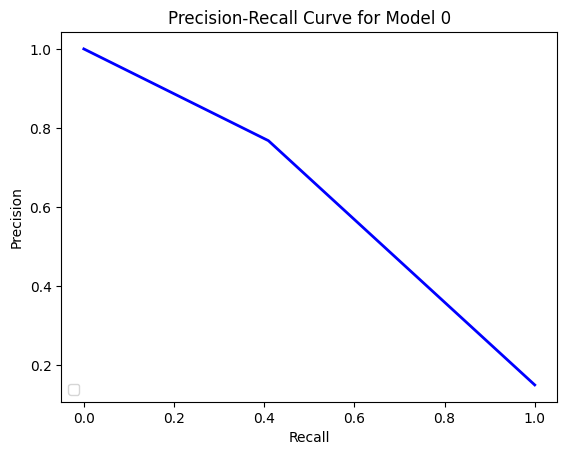

In [53]:
# ROC Curve
fpr_0, tpr_0, thresholds_0 = roc_curve(y_test, y_test_pred_0)

roc_auc_0 = auc(fpr_0, tpr_0)

plt.figure()
plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_0)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Model 0')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")

# Precision-Recall Curve
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_test, y_test_pred_0)
plt.figure()
plt.plot(recall_0, precision_0, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Model 0')
plt.legend(loc="lower left")
plt.savefig("precision_recall_curve_model_0.png")
plt.show()

## 1. RFECV Model with class weight

Training set accuracy 0.8955856507805231
Testing set accuracy 0.9011988424968995
Balanced training set accuracy 0.7940049560586626
Balanced testing set accuracy 0.9011988424968995


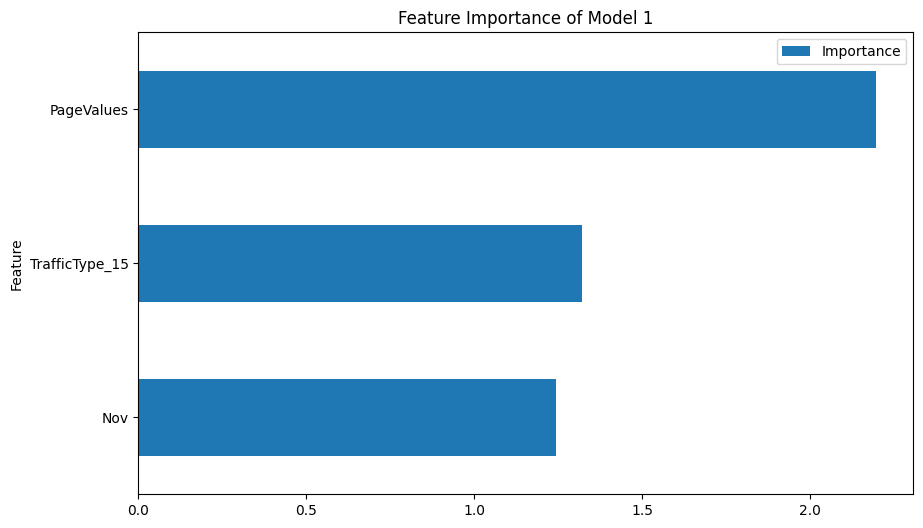

In [61]:
# RFECV: use Recursive feature elimination with cross-validation to select features.
# class_weight='balanced', solver='newton-cholesky'
estimator = LogisticRegression(class_weight='balanced', solver='newton-cholesky', max_iter=100)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)
selector = RFECV(estimator, step=1, cv=cv)
selector = selector.fit(X_train, y_train['Revenue'])

RFECV_model_1 = LogisticRegression(class_weight='balanced', solver='newton-cholesky')

RFECV_model_1.fit(X_train[X_train.columns[selector.get_support()]], y_train['Revenue'])

# Print feature importances of selected features
coefficients = RFECV_model_1.coef_[0]

feature_importance_1 = pd.DataFrame({'Feature': X.columns[selector.get_support()], 'Importance': np.abs(coefficients)})
feature_importance_1 = feature_importance_1.sort_values('Importance', ascending=True)
feature_importance_1.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title='Feature Importance of Model 1')
plt.savefig("feature_importance_model_1.png")

# Perform Prediction and print accuracy
y_train_pred_1 = RFECV_model_1.predict(X_train[X_train.columns[selector.get_support()]])
y_test_pred_1 = RFECV_model_1.predict(X_test[X_train.columns[selector.get_support()]])


print("Training set accuracy", accuracy_score(y_train_pred_1, y_train))
print("Testing set accuracy", accuracy_score(y_test_pred_1, y_test))


print("Balanced training set accuracy", balanced_accuracy_score(y_train_pred_1, y_train))
print("Balanced testing set accuracy", accuracy_score(y_test_pred_1, y_test))

For testing data: 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2055
           1       0.66      0.71      0.68       364

    accuracy                           0.90      2419
   macro avg       0.80      0.82      0.81      2419
weighted avg       0.90      0.90      0.90      2419



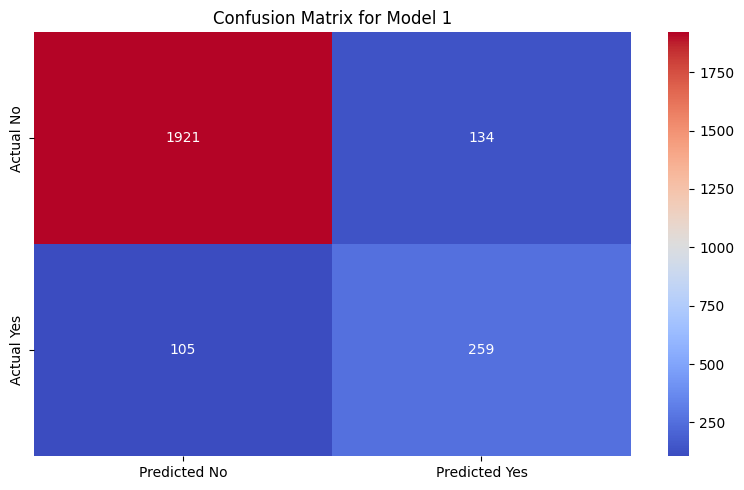

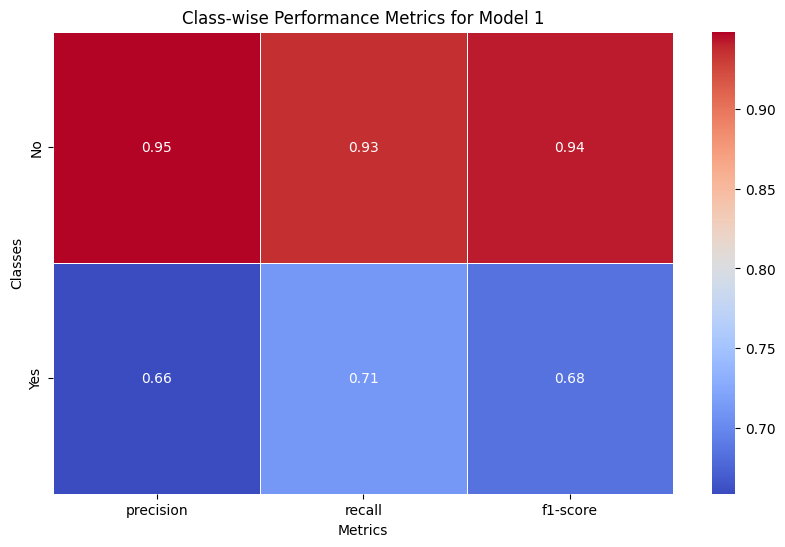

In [33]:
# Visualize the output of testing set

# Classification Report
classification_report_11=classification_report(y_test, y_test_pred_1)
print("For testing data: ")
print(classification_report_11)

# Confusion matrix with seaborn Heatmap
conf_matrix_1=confusion_matrix(y_test, y_test_pred_1)
# Seaborn Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Model 1')
plt.tight_layout()
plt.savefig("confusion_matrix_model_1.png")

# Visualize classification report better: Class-wise Performance Metrics
classification_report_12 = classification_report(y_test, y_test_pred_1, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [classification_report_12[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Model 1')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("performance_metrics_model_1.png")
plt.show()

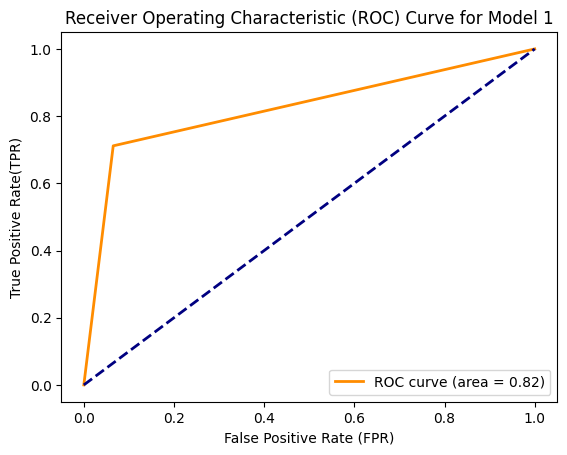

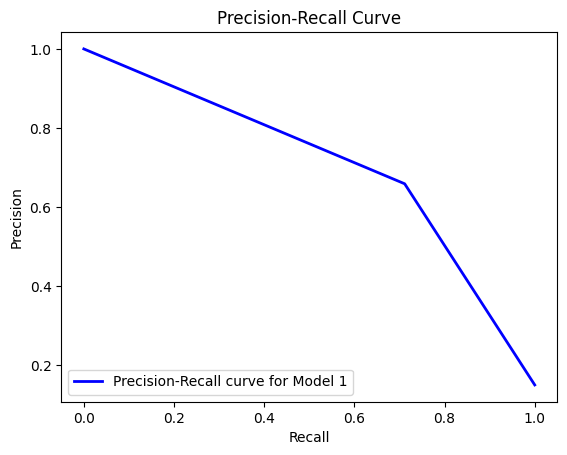

In [30]:
# ROC Curve
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_test_pred_1)

roc_auc_1 = auc(fpr_1, tpr_1)

plt.figure()
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Model 1')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")

# Precision-Recall Curve
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_test_pred_1)
plt.figure()
plt.plot(recall_1, precision_1, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig("precision_recall_curve_model_1.png")
plt.show()

## 2. Model with SMOTE Sampling

In [42]:
print('Original dataset: %s' % Counter(y_train['Revenue']))

sm = SMOTE(random_state=9)
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

print('Resampled dataset: %s' % Counter(y_train_resample['Revenue']))

Original dataset: Counter({0: 8215, 1: 1458})
Resampled dataset: Counter({0: 8215, 1: 8215})


Training set accuracy 0.8990870359099209
Testing set accuracy 0.8755684167011162
Balanced training set accuracy 0.901601275503262
Balanced testing set accuracy 0.8755684167011162


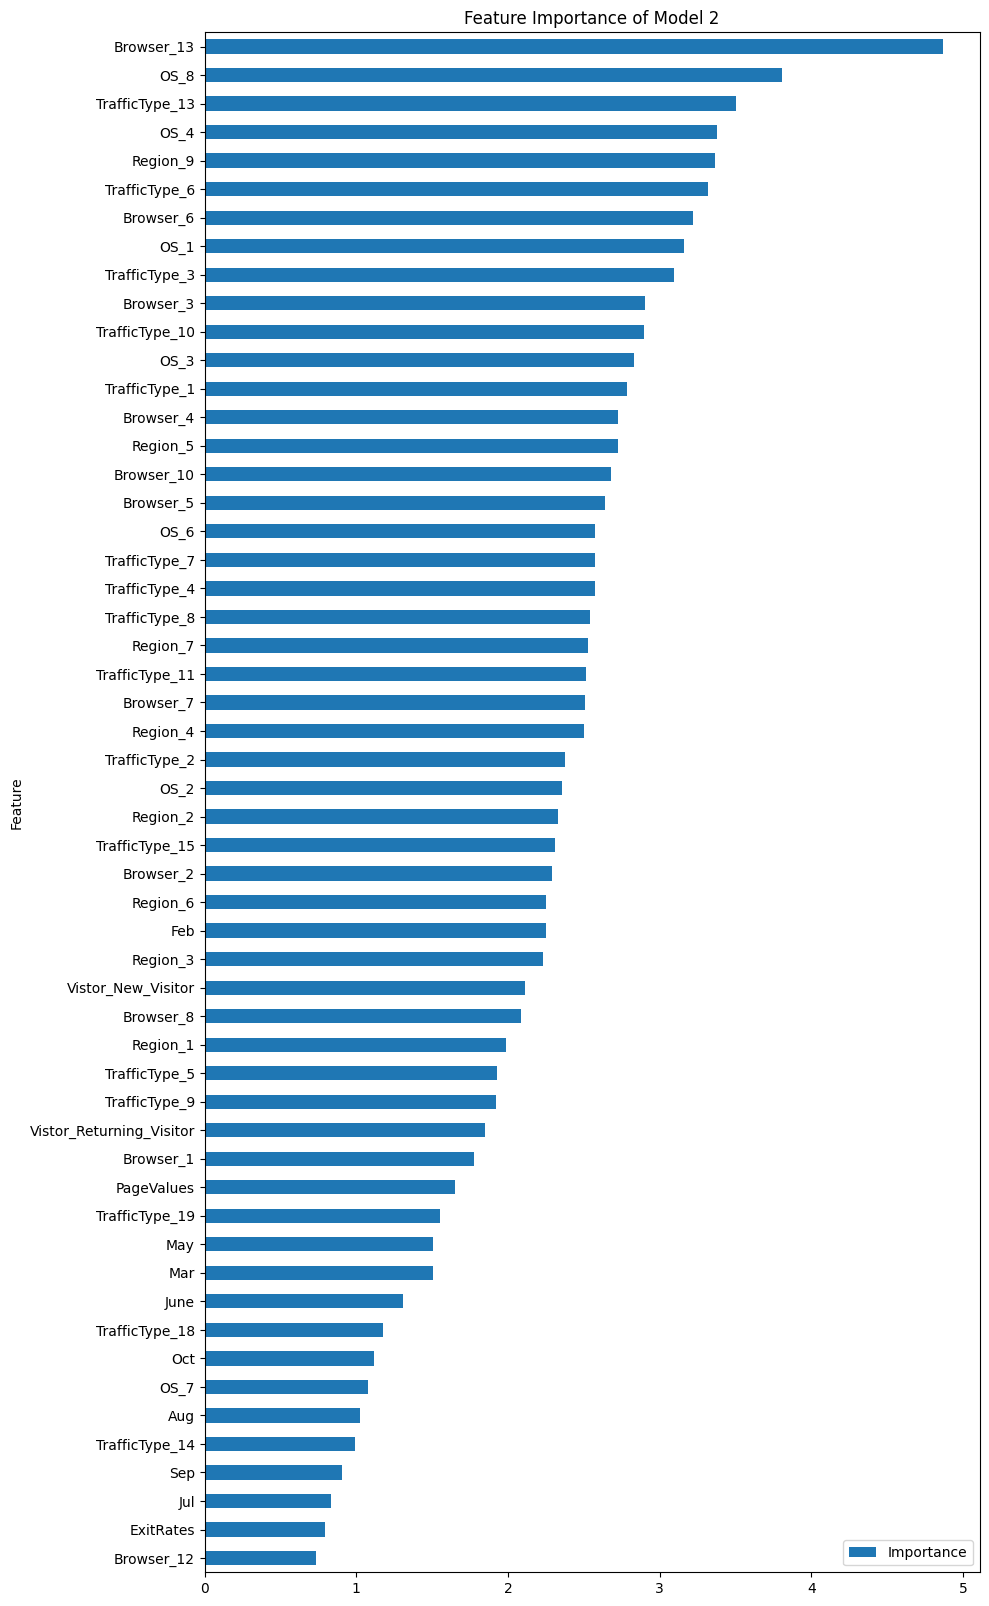

In [60]:
# RFECV: use Recursive feature elimination with cross-validation to select features.
# resample data by SMOTE, solver='newton-cholesky'
estimator = LogisticRegression(solver='newton-cholesky', max_iter=100)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)
selector = RFECV(estimator, step=1, cv=cv)
selector = selector.fit(X_train_resample, y_train_resample['Revenue'])

RFECV_model_2 = LogisticRegression(solver='newton-cholesky')

RFECV_model_2.fit(X_train_resample[X_train_resample.columns[selector.get_support()]], y_train_resample['Revenue'])

# Print feature importances of selected features
coefficients = RFECV_model_2.coef_[0]

feature_importance_2 = pd.DataFrame({'Feature': X.columns[selector.get_support()], 'Importance': np.abs(coefficients)})
feature_importance_2 = feature_importance_2.sort_values('Importance', ascending=True)
feature_importance_2.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 20), title='Feature Importance of Model 2')
plt.savefig("feature_importance_model_2.png")

# Perform Prediction and print accuracy
y_train_resample_pred_2 = RFECV_model_2.predict(X_train_resample[X_train_resample.columns[selector.get_support()]])
y_test_pred_2 = RFECV_model_2.predict(X_test[X_train_resample.columns[selector.get_support()]])


print("Training set accuracy", accuracy_score(y_train_resample_pred_2, y_train_resample))
print("Testing set accuracy", accuracy_score(y_test_pred_2, y_test))


print("Balanced training set accuracy", balanced_accuracy_score(y_train_resample_pred_2, y_train_resample))
print("Balanced testing set accuracy", accuracy_score(y_test_pred_2, y_test))

For testing data: 
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2055
           1       0.60      0.54      0.57       364

    accuracy                           0.88      2419
   macro avg       0.76      0.74      0.75      2419
weighted avg       0.87      0.88      0.87      2419



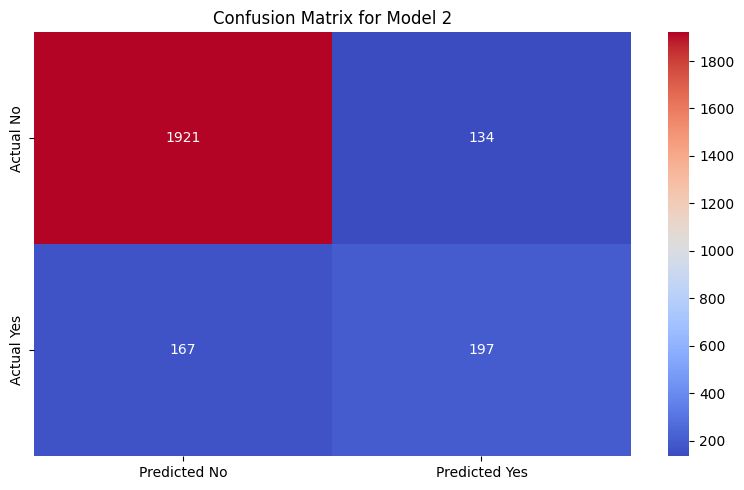

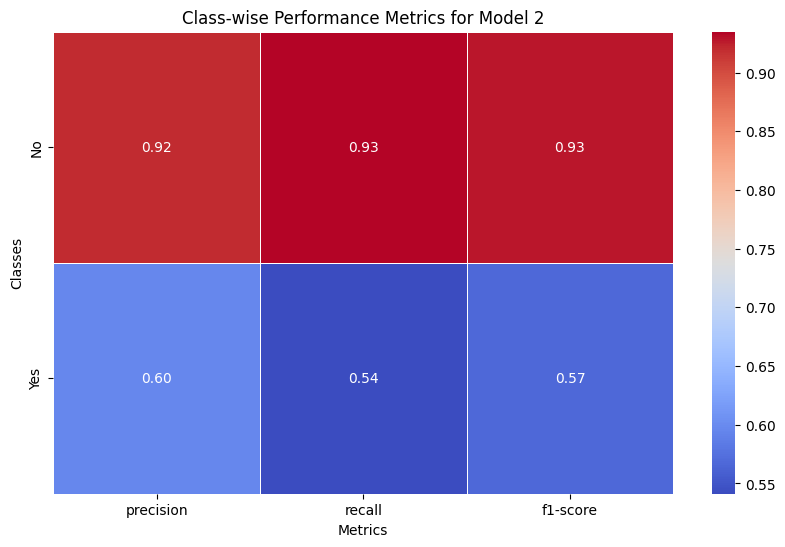

In [48]:
# Visualize the output of testing set

# Classification Report
classification_report_21=classification_report(y_test, y_test_pred_2)
print("For testing data: ")
print(classification_report_21)

# Confusion matrix with seaborn Heatmap
conf_matrix_2=confusion_matrix(y_test, y_test_pred_2)
# Seaborn Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix_2, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Model 2')
plt.tight_layout()
plt.savefig("confusion_matrix_model_2.png")

# Visualize classification report better: Class-wise Performance Metrics
classification_report_22 = classification_report(y_test, y_test_pred_2, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [classification_report_22[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Model 2')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("performance_metrics_model_2.png")
plt.show()

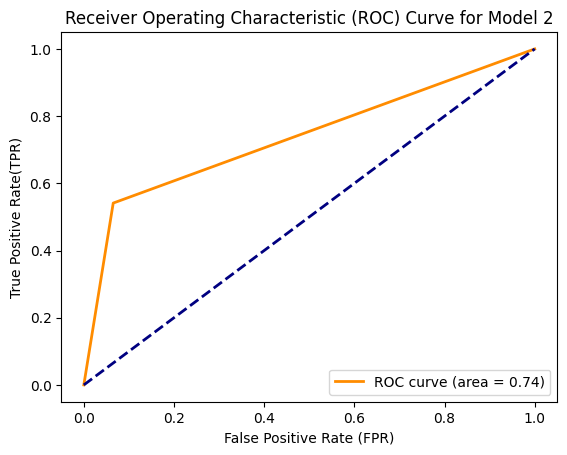

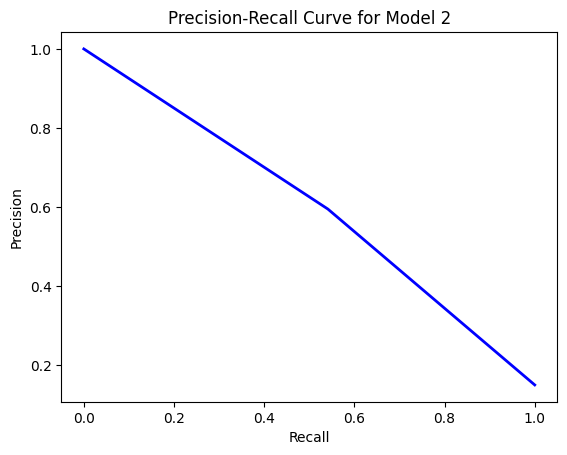

In [54]:
# ROC Curve
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_test_pred_2)

roc_auc_2 = auc(fpr_2, tpr_2)

plt.figure()
plt.plot(fpr_2, tpr_2, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Model 2')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")

# Precision-Recall Curve
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, y_test_pred_2)
plt.figure()
plt.plot(recall_2, precision_2, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Model 2')
plt.savefig("precision_recall_curve_model_2.png")
plt.show()

# Compare Different Models

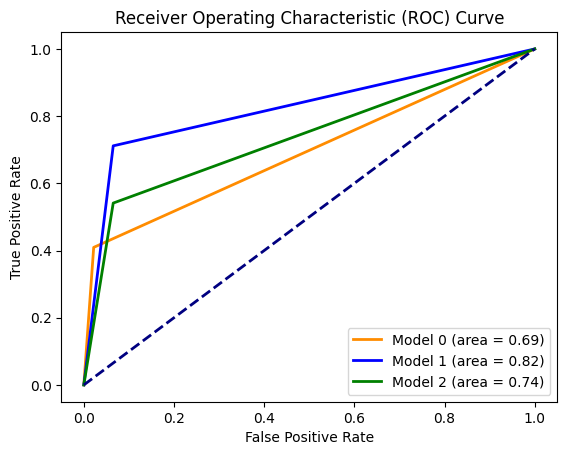

In [56]:
# ROC Curve
plt.figure()
plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label='Model 0 (area = %0.2f)' % roc_auc_0)
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label='Model 1 (area = %0.2f)' % roc_auc_1)
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='Model 2 (area = %0.2f)' % roc_auc_2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("all_models_roc_curve.png")

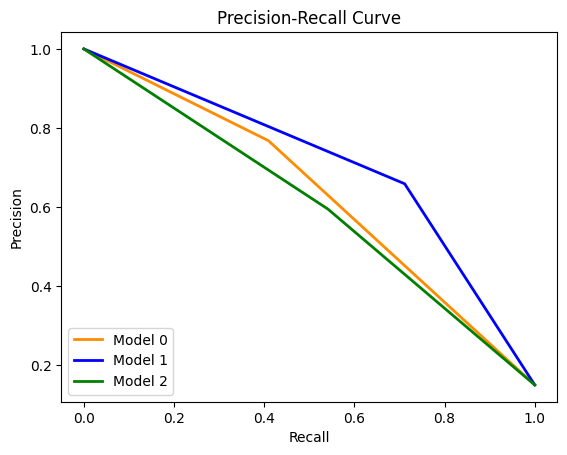

In [57]:
# Precision-Recall Curve
plt.figure()
plt.plot(recall_0, precision_0, color='darkorange', lw=2, label='Model 0')
plt.plot(recall_1, precision_1, color='blue', lw=2, label='Model 1')
plt.plot(recall_2, precision_2, color='green', lw=2, label='Model 2')
# plt.plot(recall_xgb, precision_xgb, color='green', lw=2, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig("all_models_precision_recall_curve.png")
plt.show()

In [ ]:
# # Visualize the output for training set

# # Classification Report
# training_classification_report=classification_report(y_train, y_train_pred)
# print("For training data: ")
# print(training_classification_report)

# # Confusion matrix with seaborn Heatmap
# training_conf_matrix=confusion_matrix(y_train, y_train_pred)
# # Seaborn Heatmap
# plt.figure(figsize=(8,5))
# sns.heatmap(training_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted Yes', 'Predicted No'], yticklabels=['Actual Yes', 'Actual No'])
# plt.title('Confusion Matrix for Training Data')
# plt.tight_layout()
# plt.savefig("training_confusion_matrix.png")

# # Visualize classification report better: Class-wise Performance Metrics
# training_classification_report_2 = classification_report(y_train, y_train_pred, output_dict=True)
# metrics = ['precision', 'recall', 'f1-score']
# class_metrics = {metric: [training_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# # Create a heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Class-wise Performance Metrics for Training Data')
# plt.xlabel('Metrics')
# plt.ylabel('Classes')
# plt.savefig("performance_metrics.png")
# plt.show()



In [ ]:
# # ROC Curve
# fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate(TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.savefig("roc_curve.png")

# # Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred)
# plt.figure()
# plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc="lower left")
# plt.savefig("precision_recall_curve.png")
# plt.show()